In [1]:
import os
import re
import sys
import librosa
from random import shuffle
import numpy as np
from typing import Tuple, Union
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
data_df = pd.read_csv("EMOVO_dataset/data.csv")

In [3]:
def get_max_min(files):
    min_, max_ = 100, 0
    for file in files:
        sound_file, samplerate = librosa.load(file)
        t = sound_file.shape[0] / samplerate
        if t < min_:
            min_ = t
        if t > max_:
            max_ = t

    return max_, min_

In [12]:
def extract_new(file,pad):
    X, sample_rate = librosa.load(file)
    max_ = X.shape[0] / sample_rate
    if pad:
        length = (max_ * sample_rate) - X.shape[0]
        X = np.pad(X, (0, int(length)), 'constant')
    
    stft = np.abs(librosa.stft(X))
    result = np.array([])

    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
    result = np.hstack((result, mfccs))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0) 
    result = np.hstack((result, mel))
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, contrast))
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    result = np.hstack((result, tonnetz))
    return result

In [7]:
def extract(file, pad):
    X, sample_rate = librosa.load(file)
    max_ = X.shape[0] / sample_rate
    if pad:
        length = (max_ * sample_rate) - X.shape[0]
        X = np.pad(X, (0, int(length)), 'constant')

    stft = np.abs(librosa.stft(X))

# fmin 和 fmax 对应于人类语音的最小最大基本频率
    pitches, magnitudes = librosa.piptrack(y=X, sr=sample_rate, S=stft, fmin=70, fmax=400)
    pitch = []
    for i in range(magnitudes.shape[1]):
        index = magnitudes[:, 1].argmax()
        pitch.append(pitches[index, i])

    pitch_tuning_offset = librosa.pitch_tuning(pitches)
    pitchmean = np.mean(pitch)
    pitchstd = np.std(pitch)
    pitchmax = np.max(pitch)
    pitchmin = np.min(pitch)

# 频谱质心
    cent = librosa.feature.spectral_centroid(y=X, sr=sample_rate)
    cent = cent / np.sum(cent)
    meancent = np.mean(cent)
    stdcent = np.std(cent)
    maxcent = np.max(cent)

# 谱平面
    flatness = np.mean(librosa.feature.spectral_flatness(y=X))
    
# 使用系数为50的MFCC特征
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0) #######
    mfccsstd = np.std(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
    mfccmax = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
# 色谱图
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0) ######

# 梅尔频率
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0) ######
    print(mel.shape)

# ottava对比
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0) ########

# 过零率
    zerocr = np.mean(librosa.feature.zero_crossing_rate(X)) ####

    S, phase = librosa.magphase(stft)
    meanMagnitude = np.mean(S)
    stdMagnitude = np.std(S)
    maxMagnitude = np.max(S)

# 均方根能量
    rmse = librosa.feature.rms(S=S)[0] ######
    meanrms = np.mean(rmse)
    stdrms = np.std(rmse)
    maxrms = np.max(rmse)

    ext_features = np.array([
    flatness, zerocr, meanMagnitude, maxMagnitude, meancent, stdcent,
    maxcent, stdMagnitude, pitchmean, pitchmax, pitchstd,
    pitch_tuning_offset, meanrms, maxrms, stdrms
    ])


    ext_features = np.concatenate((ext_features, mfccs, mfccsstd, mfccmax, chroma, mel, contrast))

    return ext_features

In [8]:
u = extract('EMOVO_dataset/'+data_df.file_name[0], max)

(128,)


In [9]:
file = 'EMOVO_dataset/'+data_df.file_name[0] 
X, sample_rate = librosa.load(file)
max_ = X.shape[0] / sample_rate
if 1:
    length = (max_ * sample_rate) - X.shape[0]
    X = np.pad(X, (0, int(length)), 'constant')

stft = np.abs(librosa.stft(X))
mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0) ######
print(mel.shape)

(128,)


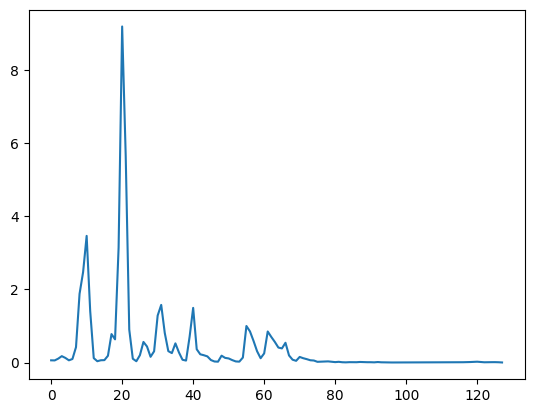

In [11]:
import matplotlib.pyplot as plt 

plt.plot(mel)

In [7]:
max, min = get_max_min('EMOVO_dataset/'+data_df.file_name)

In [8]:
train_data = pd.DataFrame(columns=['filename', 'features', 'label'])

features = []
for index, file in zip(data_df.index, data_df.file_name):
    train_data.loc[index] = [file, extract('EMOVO_dataset/'+file, max), data_df.label[index]]

In [9]:
fit = list(train_data["features"])

In [10]:
scaler = StandardScaler().fit(fit)
X = scaler.transform(fit)
Y = list(train_data["label"])

In [11]:
X = np.array(fit).shape

In [12]:
X.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [47]:
import tensorflow as tf
from keras.utils import to_categorical

data_classes = (list((train_data["label"].unique())))
Y = to_categorical(list((train_data["label"].apply(data_classes.index))))
X = np.stack(train_data["features"])

In [49]:
X.shape

(588, 312)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [13]:
input_shape = (X_train.shape[1],1)

In [51]:
X_train.shape

(423, 312)

In [15]:
import keras
model = keras.Sequential()
kernel_sizes = [5, 5]
model.add(keras.layers.Input(shape=(X_train.shape[1],1)))
for size in kernel_sizes:
    model.add(keras.layers.Conv1D(
        filters = 32,
        kernel_size = size,
        padding = 'same'
    ))  # 卷积层
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(7, activation='softmax'))  # 分类层
optimzer = keras.optimizers.Adam(learning_rate= 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimzer, metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 312, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 312, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 312, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 312, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 312, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 312, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 312, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 312, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       319,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,479 (1.24 MB)

 Trainable params: 325,287 (1.24 MB)

 Non-trainable params: 192 (768.00 B)

In [18]:
from datetime import datetime  
name = datetime.now().strftime("ser_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]



history = model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=256,
                       epochs=1000,
                       callbacks=callbacks)


print(f"Loss : {model.evaluate(X_test,y_test)[0]}, Accuracy : {model.evaluate(X_test,y_test)[1]}")

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.1732 - loss: 2.6485 - val_accuracy: 0.1604 - val_loss: 4.8462
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1663 - loss: 2.6061 - val_accuracy: 0.1604 - val_loss: 4.2321
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1915 - loss: 2.4732 - val_accuracy: 0.1698 - val_loss: 3.9447
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1799 - loss: 2.5184 - val_accuracy: 0.1792 - val_loss: 3.6874
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2030 - loss: 2.2758 - val_accuracy: 0.2075 - val_loss: 3.3878
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1985 - loss: 2.3391 - val_accuracy: 0.2170 - val_loss: 3.1789
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1904 - loss: 2.3100 - val_accuracy: 0.2170 - val_loss: 2.9787
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2103 - loss: 2.2548 - val_accuracy: 0.2547 - 

### ROCKET

In [55]:
from sktime.transformations.panel.rocket import Rocket
Xn = train_data["features"]


In [96]:
import pandas as pd

# Assuming your DataFrame is named 'df' and the column containing NumPy arrays is 'array_column'
def convert_to_rows(array):
    """Converts a NumPy array to a Pandas Series."""
    return pd.Series(array)

X = (train_data['features'].apply(convert_to_rows)).to_numpy()

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [92]:
X.shape

(588, 312)

In [98]:
X_train[0]

array([ 1.03913940e-01,  1.16918945e-01,  4.98591036e-01,  6.91306839e+01,
        1.25000000e-02,  4.91027145e-03,  3.18350586e-02,  1.93383539e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.10000000e-01,
        3.31350169e-02,  1.41323665e-01,  2.91760249e-02, -2.88435181e+02,
        5.50728378e+01, -4.01296387e+01,  1.95592842e+01, -8.34246254e+00,
       -1.37986317e+01, -2.29263191e+01,  8.45240593e-01, -1.28851871e+01,
       -2.78754950e+00, -1.07358627e+01, -9.34252262e-01, -8.63516998e+00,
        2.62261248e+00, -1.72914658e+01, -1.19062510e+01, -2.32286954e+00,
       -8.86913967e+00,  6.83052778e-01,  9.12650299e+00,  8.85004330e+00,
        1.62932949e+01,  1.13906841e+01,  5.32557487e+00, -4.46631342e-01,
        4.71856403e+00,  2.21630859e+00,  1.03134451e+01,  3.46971959e-01,
       -4.57345307e-01, -3.10386157e+00,  3.33023000e+00, -3.00312817e-01,
       -2.89699078e-01, -3.21450281e+00, -2.06911898e+00, -2.18551540e+00,
        1.14130723e+00, -

In [93]:
trf = Rocket(num_kernels=512) 
trf.fit(X_train) 
X_train = trf.transform(X_train) 
X_test = trf.transform(X_test) 
X_val = trf.transform(X_val) 
print(X_train.shape)

(1, 1024)


In [94]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.464945,20.515377,0.486998,13.475472,0.512545,13.781878,0.498607,12.969245,0.482269,10.576056,...,0.51773,16.585114,0.401891,6.140023,0.484634,12.625414,0.555556,31.429398,0.449173,9.29497


In [23]:
import keras
model = keras.Sequential()
kernel_sizes = [5, 5]
model.add(keras.layers.Input(shape=(X_train.shape[1],1)))
for size in kernel_sizes:
    model.add(keras.layers.Conv1D(
        filters = 32,
        kernel_size = size,
        padding = 'same'
    ))  # 卷积层
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32))
model.add(keras.layers.BatchNormalization(axis = -1))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(7, activation='softmax'))  # 分类层
optimzer = keras.optimizers.Adam(learning_rate= 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimzer, metrics=['accuracy'])

In [24]:
from datetime import datetime  
name = datetime.now().strftime("ser_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]



history = model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       epochs=1000,
                       callbacks=callbacks)


print(f"Loss : {model.evaluate(X_test,y_test)[0]}, Accuracy : {model.evaluate(X_test,y_test)[1]}")

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1
'y' sizes: 423


### LSTM

In [218]:
X_train.shape

(423, 312)

In [221]:
from keras import layers, models
def get_model():
    inputs = layers.Input(shape=(X_train.shape[1],1))
    encoder = layers.LSTM(128)(inputs)
    drop = layers.Dropout(0.3)(encoder)
    hidden = layers.Dense(32, activation='relu')(drop)
    outputs = layers.Dense(7, activation='softmax')(hidden)
    
    model = models.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

    return model

In [222]:

LSTM_model = get_model()
LSTM_model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 312, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,919 (277.03 KB)

 Trainable params: 70,919 (277.03 KB)

 Non-trainable params: 0 (0.00 B)

In [223]:


from datetime import datetime  
name = datetime.now().strftime("ser_lstm_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


LSTM_history = LSTM_model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       verbose=1,
                       callbacks=callbacks)


print(f"Loss : {LSTM_model.evaluate(X_test,y_test)[0]}, Accuracy : {LSTM_model.evaluate(X_test,y_test)[1]}")

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.1282 - loss: 2.0847 - val_accuracy: 0.1132 - val_loss: 1.9534
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.1376 - loss: 1.9695 - val_accuracy: 0.1509 - val_loss: 1.9527
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.1371 - loss: 1.9475 - val_accuracy: 0.1792 - val_loss: 1.9482
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.1251 - loss: 1.9580 - val_accuracy: 0.2170 - val_loss: 1.9407
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.1578 - loss: 1.9562 - val_accuracy: 0.1792 - val_loss: 1.9336
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.1665 - loss: 1.9395 - val_accuracy: 0.1698 - val_loss: 1.9355
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.1362 - loss: 1.9406 - val_accuracy: 0.2358 - val_loss: 1.9280
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.1418 - loss: 1.9410 - val_a